In [174]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-os1q1fq9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-os1q1fq9
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [175]:
pip install pandas numpy torch torchvision scikit-learn


In [176]:
import pandas as pd

image_folder_path = "/content/cat_dog1.zip"

csv_path = "/content/cat_dog1.csv"
df = pd.read_csv(csv_path)

In [177]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [178]:
import clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

In [179]:
from PIL import Image

In [180]:
import os
from zipfile import ZipFile
# Extract the contents of the uploaded zip file
uploaded_zip_path = "/content/cat_dog1.zip"
extracted_folder_path = "/content/extracted_dataset"

with ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Set the path to the folder containing cat and dog images
image_folder_path = os.path.join(extracted_folder_path, "cat_dog1")

In [181]:
# Extract CLIP embeddings for training set
train_embeddings = []
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder_path, row['image'])
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    embedding = model.encode_image(image)
    train_embeddings.append(embedding.cpu().detach().numpy())

In [182]:
# Extract CLIP embeddings for testing set
test_embeddings = []
for _, row in test_df.iterrows():
    image_path = os.path.join(image_folder_path, row['image'])
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    embedding = model.encode_image(image)
    test_embeddings.append(embedding.cpu().detach().numpy())

# Fisher Manuelly

# Draft 1

In [183]:
# Organize the extracted CLIP embeddings into a feature matrix
X_train = torch.tensor(train_embeddings).squeeze()
X_test = torch.tensor(test_embeddings).squeeze()

# Convert labels to a tensor
y_train = torch.tensor(train_df['labels'].values)
y_test = torch.tensor(test_df['labels'].values)

# Fisher algorithm parameters
C = 0.1
num_classes = 2

# Separate the training set into different classes
X_train_class_0 = X_train[y_train == 0]
X_train_class_1 = X_train[y_train == 1]

# Compute the mean vectors for each class
mean_vector_class_0 = torch.mean(X_train_class_0, dim=0)
mean_vector_class_1 = torch.mean(X_train_class_1, dim=0)

# Compute the within-class scatter matrix (Sw)
S1 = (X_train_class_0 - mean_vector_class_0).T @ (X_train_class_0 - mean_vector_class_0)
S2 = (X_train_class_1 - mean_vector_class_1).T @ (X_train_class_1 - mean_vector_class_1)
Sw = S1+S2
# Calculate the linear discriminant vector
w = C * torch.inverse(Sw) @ (mean_vector_class_1 - mean_vector_class_0)
X_test_projected = X_test @ w.T

# Apply a threshold to classify into classes
threshold = 0
y_pred = (X_test_projected >= threshold).int()

# Convert the predictions to a NumPy array
y_pred = y_pred.numpy()

# Metrics Section

In [184]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [185]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [186]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[201   0]
 [  6 193]]


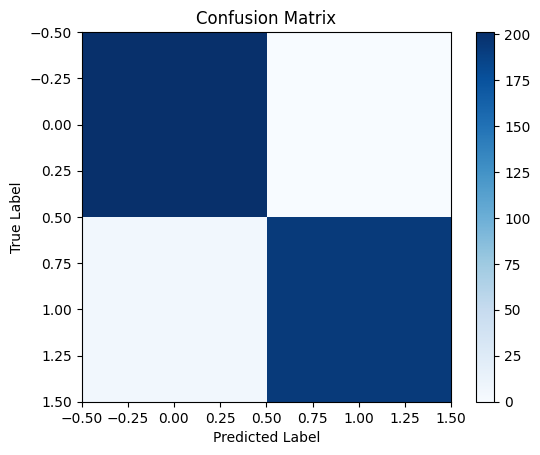

In [187]:
# Visualize the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [188]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9850
Precision: 1.0000
Recall: 0.9698
F1 Score: 0.9847
